In [1]:
%matplotlib inline
import os, sys
from importlib import reload
import numpy as np

import matplotlib.pyplot as plt

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import pytorchnet

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

0.4.1


In [3]:
boston=np.load('boston.npz')
data=boston['data']

np.random.shuffle(data)

test=data[:50]
train=data[50:]
print(train.shape,test.shape)

(456, 14) (50, 14)


10000 10.968870162963867
20000 8.318648338317871
30000 7.362969875335693
40000 6.836792945861816
50000 5.649820804595947
60000 5.942462921142578
70000 5.115471363067627
80000 6.59487771987915
90000 5.155945777893066
100000 4.741133213043213


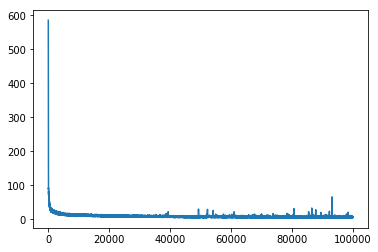

In [93]:
class DropoutNet(pytorchnet.LinearNet):
    def _getLayer(self,inChannels,outChannels,bias):
        return torch.nn.Sequential(
            torch.nn.Linear(inChannels,outChannels,bias),
            torch.nn.Dropout(0.25),
            torch.nn.PReLU()
        )

net=DropoutNet(train.shape[1]-1,1,[50,50,50])
net.apply(pytorchnet.normalInit)

xt=torch.from_numpy(train[:,:-1]).float()
yt=torch.from_numpy(train[:,-1:]).float()

loss=torch.nn.MSELoss()
opt=torch.optim.Adam(net.parameters())

iters=100000
losses=[]

for i in range(1,iters+1):
    opt.zero_grad()
    prices=net(xt)
    lossval=loss(prices,yt)
    
    lossval.backward()
    opt.step()
    
    losses.append(lossval.item())
    
    if i%(iters//10)==0:
        print(i,losses[-1])
        
plt.plot(losses)

2.11159606552124


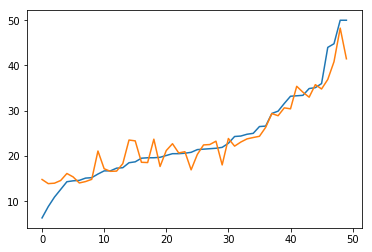

In [94]:
inds=sorted(range(test.shape[0]),key=lambda i:test[i,-1])
testsorted=test[inds]

with torch.no_grad():
    net.eval()
    testxt=torch.from_numpy(testsorted[:,:-1]).float()
    testprices=net(testxt).data.numpy()

print(np.average(np.absolute(testsorted[:,-1]-testprices[:,0])))
plt.plot(testsorted[:,-1])
plt.plot(testprices[:,0])